# Motion Capture data

This dataset was taken from Reynolds, Zachs and Braver (2007) model of event segmentation. [[paper](https://www.ncbi.nlm.nih.gov/pubmed/21635310)] [[dataset/code]](https://wustl.app.box.com/s/0l0r2w2jg715cx567bli). The paper is worth reading butone of the main take away is that prediction errors are indicative of event boundaries, meaning that prediction errors are lower within an event than between them.

The data are 3d motion capture data of people moving. At each point in time, the position of the human in the recording is described by 18 points in (x, y, z) coordinate space. Motion is indicated by the updating of these points from timepoint to timepoint. There are 13 distinct events in the dataset and approximately 10 timepoints per event.

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_file = './datasets/motion_data.pkl'
motion_data = pd.read_pickle(data_file)
print "Number of events:", set(motion_data.EventNumber)
print "Timepoint / event:", len(motion_data) / float(len(set(motion_data.EventNumber)))

Number of events: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
Timepoint / event: 10.5384615385


Formally, each scence vector $s$ is a 54D vector of the 18 points in coordinate space and each event consistest of an ordered list of scene vectors. Below is a visualization of a single event in (x, y) coordinate space. Each of the events is a 3-4s long clip, sampled at 3 Hz.

For the plots on the left, you can see the trajectory of individual points in space over time. Time is represented by color, with yellow indicating early in time and red later in time (such that each of the 18 points in (x, y) space at a particular moment in time is represented with the same color). The triangle markers also denote time, getting larger across time.

The plots on the right, you can see a snapshot of an event at two moments in time. These plots should make the motion of the person more clear.

In [3]:
def plot_event(event_number):
    fig, axes = plt.subplots(1, 2, figsize=(8.3, 4), gridspec_kw={'wspace': 0.3})
    e = motion_data.loc[motion_data.EventNumber == event_number, :]
    cols = e.columns[:-1]
    e = e[cols].values

    # loop through and plot each point as it moves in time.
    cc = sns.color_palette("YlOrRd", n_colors=e.shape[0])
    for ii in range(e.shape[0]-1):
        for jj in range(18):
            axes[0].plot([e[ii, jj], e[ii+1, jj]], [e[ii, 18+jj], e[ii+1, 18+jj]],
                     color=cc[ii], marker='^', markersize=ii)
    axes[0].set_xlabel('x-coordinate')
    axes[0].set_ylabel('y-coordinate')
    
    def connect(ax, t, color, linestyle, label=None):
        # plot the connections between the points in an ordered way
        kwargs = dict(color=color, linestyle=linestyle)
        ax.plot(e[t, 0:18], e[t, 18:36], 'o', color=color, label=label)
        ax.plot(e[t, 0:4], e[t, 18:22], **kwargs)
        ax.plot(e[t, 4:7], e[t, 22:25], **kwargs)
        ax.plot(e[t, [0,4]], e[t, [0,22]], **kwargs)
        ax.plot(e[t, [0,7]], e[t, [18, 18+7]], **kwargs)
        ax.plot(e[t, [7,8]], e[t, [18+7, 18+8]], **kwargs)
        ax.plot(e[t, [7,12]], e[t, [18+7, 18+12]], **kwargs)
        ax.plot(e[t, [8,12]], e[t, [18+8, 18+12]], **kwargs)
        ax.plot(e[t, 8:12], e[t, (18+8):(18+12)], **kwargs)
        ax.plot(e[t, 12:16], e[t, (18+12):(18+16)], **kwargs)
        ax.plot(e[t, [1,18]], e[t, [18+1, 18+18]], **kwargs)
        ax.plot(e[t, [4,18]], e[t, [18+4, 18+18]], **kwargs)
        ax.plot(e[t, [16,17]], e[t, [18+16, 18+17]], **kwargs) 
        ax.plot(e[t, [8,16]], e[t, [18+8, 18+16]], **kwargs)
        ax.plot(e[t, [12,16]], e[t, [18+12, 18+16]], **kwargs)
        
    connect(axes[1], 4, [0.5, 0.5, 0.5], '--', label='t=4')
    connect(axes[1], 5, 'k', '-', label='t=5')
    axes[1].legend()


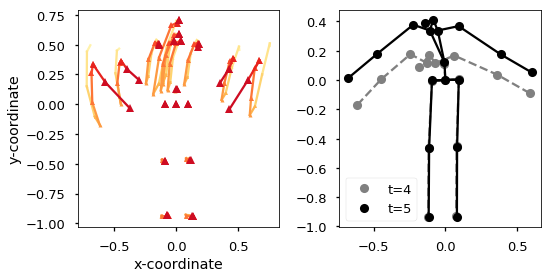

In [4]:
plot_event(1)

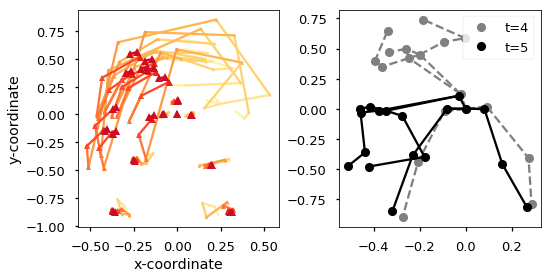

In [5]:
plot_event(8)

# SEM Model
We can use these events generatively to create set of training data to evaluate the SEM model. To do so, we sample a random list of events and concetanate their scene vectors into a single vector:

$X = [s_1, s_2, ... , s_n]$

and create a corresponding vector of the event identities

$y = [e_i, e_i, ..., e_j]$

We can the train the SEM model to predict $X_{t+1}|X_{1:t}$. We'll evaluate the model by plotting how well it predicts the event labels, using the adjusted [Rand Index](https://en.wikipedia.org/wiki/Rand_index) as our clustering measure. Our choice of data is stochastic, as is the initialization of the model, so this will vary every time we run it.

*N.B.* The SEM is trained solely on it's ability to predict the next vector in the time series across all events $\Pr(X_t|X_{1:t-1}, \theta)$, where $\theta$ is the set of all parameters. The model is not provided with any event labels or an objective function that implicitly uses them. Thus, its segmentation is fully unsupervised (though the problem of choosing $\theta$ to maximize the Rand Index can be thought of as a supervised optimization problem).

In [6]:
import numpy as np
np.random.seed(12323512)
from opt.utils import generate_random_events
X_train, y_train = generate_random_events(10, data_file=data_file)

Using TensorFlow backend.


In [7]:
from sklearn.preprocessing import scale
X_train = scale(X_train)

It is important to note that the steepness of the likelihood function scales as a function of the dimenionsality the data. Here, we've scaled our data such that each scence vector $X\in \mathbb{R}^D$ has features $x_i$ with zero mean and a standard deviation of 1. Given our likelihood function:

$$\mathcal{L}(X_t|e, \theta) = \mathcal{N}\left(X_t; f(X_{1:t-1}, e, \theta), \beta\text{I}\right )$$

the log likelihood can be shown with a little bit of algebra to be:

$$\log \mathcal{L}(X_t|e, \theta) = -\frac{1}{2\beta}\sum_{i}^{D}(x_i-\hat x_i )^2-Z(\beta)$$

where $\hat x_i$ are the features of the vector $\hat X_i=f(X_{1:t-1}, e, \theta)$ and where $Z(\beta)=D\log\sqrt{2\pi\beta}$ is the partition funciton (which does not depend on $X_t$). Because $\sum_{i}^{D}(x_i-\mu_i )^2$ will scale as a function of $D$, the relative likelihoods of two hypothesis models depends on $D$ as well. To make this concreate, we can consider two toy event models A and B, each of which guess the correct location with addive gaussian noise. Model A will make it's guess by drawing from the distribution $\hat X_t \sim X_t + \mathcal{N}(0, \sigma_A)$ whereas model B will draw a guess from $\hat X_t \sim X_t + \mathcal{N}(0, \sigma_B)$, where $X_t$ is the veridical value of the scene vector at time $t$. With some algebra, we can show that the difference in likelihood between the two hypotheses (in expectation) is: 

$$\mathbb{E}[\log \mathcal{L}_A]- \mathbb{E}[\log \mathcal{L}_B] = -\frac{D}{2\beta}(\sigma_A - \sigma_B)$$

Thus, $\frac{D}{2\beta}$ acts as a scaling factor, controlling the degree to which one event model is favored over another. When $D$ is large, then the difference in probability between the two models is magnified. This is an undesirable property of the model because the embedding space of our vectors is typically chosen for unrealted concerns. To compensate, we can scale the noise parameter by setting it as a funciton of $D$:

$$ \beta = \beta(D) = \beta_0 \times D \times \sigma_{\text{norm}}$$

where $\beta_0$ is a free parameter and $\sigma_{\text{norm}}$ is the variance of the features of the data (this is typically 1 for scalled data).

lambda = 10.0
alpha = 10.0
beta = 7.95


Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Rand Index: 0.300685336019


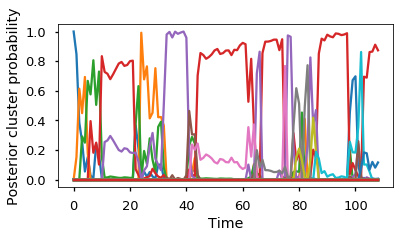

In [8]:
import tensorflow as tf
from models import SEM, KerasSimpleRNN
from opt.utils import evaluate
# from keras import o

# set the parameters for the models
_, D = X_train.shape

t_horizon = 2 # time horizon to consider

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=100, optimizer='adam',
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='tanh', hidden_act2='tanh',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(X_train.flatten()) # this equals 1 if the data are scaled
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta

r, post, pe, log_like, log_prior = evaluate(X_train, y_train, Omega, 
                                            save=False, return_pe=True, split_post=True)
print "Adjusted Rand Index:", r
plt.figure(figsize=(6, 3.0))
plt.plot(post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
tf.Session().close()

That's not great, but it's well above chance which is good enough for now.

For comparison, let's compare at the max posterior cluster to the true event labels are shown below (the colors are not consistent between the two due to label switching, which is not important)

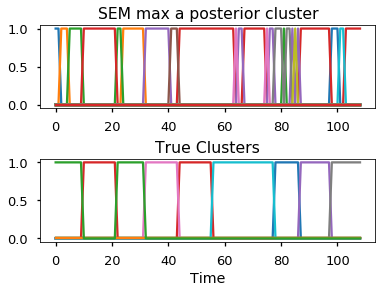

In [9]:
import numpy as np
fig, axes = plt.subplots(2, 1)

max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')

y_clust = np.zeros((y_train.shape[0], 13))
for ii, y0 in enumerate(y_train):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.6)
plt.show()

It's very important that both the prior and the posterior contribute to the clustering process. For this to happen, the scale of the differences between the different hypothesis in terms of log-likelihood and log-prior not be drastically different. For example, if the difference likelihood between two event models is ~100 and the difference between the same two is ~5 in the log-prior than the likelihood will dominate the clustering. 

This scaling can be controled by the $\beta$ parameter, that is, the likehood noise parameter.

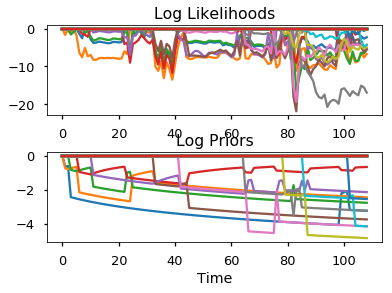

In [10]:
import numpy as np
fig, axes = plt.subplots(2, 1)

axes[0].plot(log_like)
axes[0].set_title('Log Likelihoods')

axes[1].plot(log_prior)
axes[1].set_title('Log Priors')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()

One of the predictions of previous event models is that prediction errors should be larger at event boundaries than at all other time points. Here, we evaluate the prediction by looking at the prediction error (measured by the absoluted Euclidean distance between the predicted and observed scene vectors) split by whether there was a grand-truth event boundary. 

On the left is the distribution of prediction errors (conditional on the last observed event model, not the MAP event model) for boundary/non-boundary scences. On the right is an R.O.C. curve of a logistic model trained to predict boundaries based on the prediction errors.

Mean PE at Event Boundaries:    8.2202367401
Mean PE for all other scences:  4.70946055636
t(10.1) = 3.23; p = 0.00934403


/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


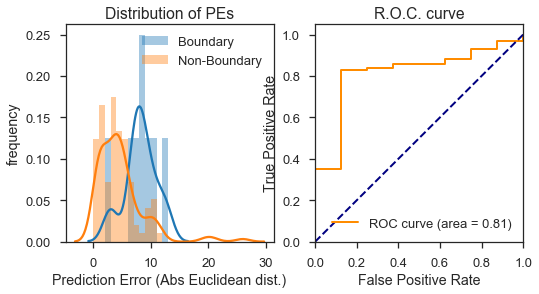

In [11]:
# plot the prediction errors as a function of event boundaries
pe_nonbound = []
pe_bound = []
for ii, y0 in enumerate(y_train[1:], start=1):
    # as an approximation, we consider an event boundary when the event type changes
    if y_train[ii - 1] == y0:
        pe_nonbound.append(pe[ii])
    else:
        pe_bound.append(pe[ii])

        
# Are PEs larger for event boundaries? t-test with unequal variance/sample size:
print "Mean PE at Event Boundaries:   ", np.mean(pe_bound)
print "Mean PE for all other scences: ", np.mean(pe_nonbound)

from scipy.stats import ttest_ind
t, p = ttest_ind(pe_bound, pe_nonbound, equal_var=False)
n1 = len(pe_bound)
n2 = len(pe_nonbound)
s1 = np.var(pe_bound)
s2 = np.var(pe_nonbound)
df = ((s1/n1 + s2/n2)**2) / ( ((s1/n1)**2)/(n1-1)  + ((s2/n2)**2)/(n2-1) )

print "t(%.1f) = %.2f; p = %g" % (df, t, p)
        
# Calculate the R.O.C curve using the PEs to classify event boundaries

# fit a logistic model, boundary ~ PE
import statsmodels.api as sm
X = np.reshape(np.concatenate([pe_bound, pe_nonbound]), (-1, 1))
X = sm.add_constant(X)
y = np.reshape(np.concatenate([np.zeros(len(pe_bound)),
                    np.ones(len(pe_nonbound))]), (-1, 1))
res = sm.Logit(y, X).fit(disp=0)
# Evaluate logistic model with ROC curve
from sklearn.metrics import roc_curve, auc
y_hat = res.predict(X)
fpr, tpr, thr = roc_curve(y, y_hat)
roc_auc = auc(fpr, tpr)

        
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 2, figsize=(8.2, 4), gridspec_kw=dict(wspace=0.2))  
    
    # plot the distribution of prediction errors
    ax = axes[0]
    sns.distplot(pe_bound, ax=ax, label='Boundary', bins=np.arange(0, 20, 1.0))
    sns.distplot(pe_nonbound, ax=ax, label='Non-Boundary', bins=np.arange(0, 20, 1.0))
    ax.legend()
    ax.set_xlabel('Prediction Error (Abs Euclidean dist.)')
    ax.set_ylabel('frequency')
    ax.set_title('Distribution of PEs')
#     ax.set_xlim([-1, 15])

    # plot the ROC curve
    ax = axes[1]
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('R.O.C. curve')
    plt.legend(loc="lower right")
    plt.show()

Imporatantly, PEs tend to be larger at event boundaries and classification based on these boundaries are well above chance.

# Comparison of predictions with vanila RNN
How well does the SEM model do against a model that doesn't segment into events? We can compare it an RNN without the hierachy. Since we only make on pass through the data, we can compare the prediction errors at each time step those of a single event model.

Widget Javascript not detected.  It may not be installed or enabled properly.


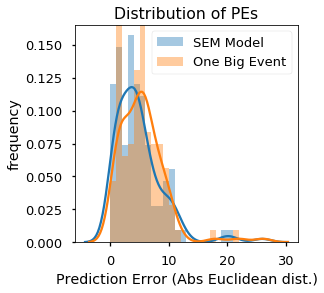

PEs for SEM:       mean=4.92, std=4.20
PEs for One Event: mean=5.46, std=3.97
t(216) = 2.31; p = 0.0226064


In [12]:
from tqdm import tnrange
N, D = X_train.shape

event_model = f_class(D, **f_opts)
pe_noseg = [None] * (N - 1)

for ii in tnrange(N-1):
    y_hat = event_model.predict_next(X_train[0:ii+1, :])
    pe_noseg[ii] = np.linalg.norm(y_hat - X_train[ii+1, :])
    event_model.update(X_train[ii, :], X_train[ii+1, :])
tf.Session().close()

# plot all of the results!
fig, ax = plt.subplots(1, 1, figsize=(4, 4))  

# plot the distribution of prediction errors
sns.distplot(pe, ax=ax, label='SEM Model', bins=np.arange(0, 25, 1.0))
sns.distplot(pe_noseg, ax=ax, label='One Big Event', bins=np.arange(0, 25, 1.0))
ax.legend()
ax.set_xlabel('Prediction Error (Abs Euclidean dist.)')
ax.set_ylabel('frequency')
ax.set_title('Distribution of PEs')
plt.show()

print 'PEs for SEM:       mean=%0.2f, std=%0.2f' % (np.mean(pe), np.std(pe))
print 'PEs for One Event: mean=%0.2f, std=%0.2f' % (np.mean(pe_noseg), np.std(pe_noseg))
t, p = ttest_ind(pe_bound, pe_nonbound, equal_var=True)
df = 2 * len(pe) - 2

print "t(%d) = %.2f; p = %g" % (df, t, p)

As we can see, the SEM model does a better job predicting the next scene vector, on average, than treating the data as one big event.

# Evaluation of event model

One question we can ask of our model is how well do the event models generate seperate predictions for the seperate events? 

Well, our likelihood function for each event is:

$\Pr(X_{t+1}|X_{1:t}, e) = \mathcal{N}(X_t; f(X_{1:t}, \theta), \sigma I)$

One way to evaluate our NN model for events (i.e. $f(X_{1:t}, \theta)$) is to train a NN for each event (i.e. conditioned on an event) and compare the error distribution for each scene in that event vs error distribution for predicted by the NN in all of the other events. Specifically, because we can estimat the value of $\sigma$ and for an event in our sample and compare that to the estimate value of $\sigma$ for that model on all other events.

Sepearation between these lines (which may reflect overfitting) is necessary for a single event model to capture it's own dynamics while failing to capture the dynamics of the other events. As before, we can evalute the seperation in this measure with an R.O.C. analysis.

This is highly similar to saying the within event prediction error (pe) should be lower than the between event (event boundary) pe. 

Widget Javascript not detected.  It may not be installed or enabled properly.


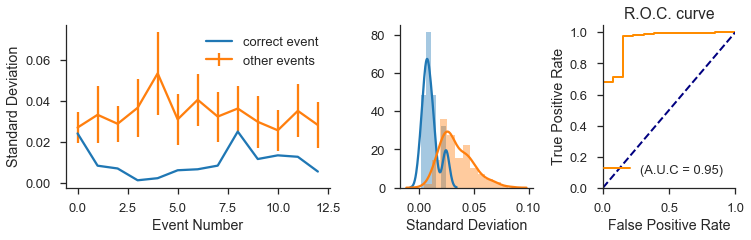

In [13]:
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from tqdm import tnrange

n_events = len(set(motion_data.EventNumber))

sigma_sq = np.zeros(n_events)
sigma_sq_cross = np.zeros((n_events, n_events-1))

def pull_event(event_number):
    e = motion_data.loc[motion_data.EventNumber == event_number, :]
    cols = e.columns[:-1]
    return e[cols].values


for p in tnrange(n_events):
    
    e = pull_event(p)
    
    # train a model with an event sequence, evaluate it's errors on other event sequences
    X = e[:-1]
    y = e[1:]

    N, D =  X.shape
    model = f_class(D, **f_opts)
    y_hat = np.zeros(y.shape)
    for ii in range(X.shape[0]):
        model.update(X[ii,:], y[ii,:])
        y_hat[ii,:] = model.predict_next(X[ii, :]) # generate the predicted points in space for the event
    # the model was trained on
    
    # get the variance of the prediction error (similar to the likelihood)
    sigma_sq[p] = np.var(np.array(y - y_hat).flatten()) 

    events = range(n_events)
    events.remove(p)
    for t, p0 in enumerate(events):
        """ Loop through all of the other events and estimate the value of sigma for 
        the given event model"""
        e0 = pull_event(p0)

        X0 = e0[:-1]
        y0 = e0[1:]
        y0_hat = np.zeros(y0.shape)
        for ii in range(X0.shape[0]):
            y0_hat[ii,:] = model.predict_next(X0[ii, :])
        
        # prediction for the location in space for events the model wasn't trained on
        sigma_sq_cross[p, t] = np.var(np.array(y0 - y0_hat).flatten())

# fit a logistic model where sigma predicts the correct event
X = np.reshape(np.concatenate([sigma_sq, sigma_sq_cross.flatten()]), (-1, 1))
X = sm.add_constant(X)
y = np.reshape(np.concatenate([np.zeros(len(sigma_sq)),
                    np.ones(len(sigma_sq_cross.flatten()))]), (-1, 1))
res = sm.Logit(y, X).fit(disp=0)
y_hat = res.predict(X)

# ROC analysis on the logistic model
fpr, tpr, thr = roc_curve(y, y_hat)
roc_auc = auc(fpr, tpr)
        
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3),
                             gridspec_kw=dict(width_ratios=[2, 1, 1], wspace=0.4))
    
    ax = axes[0]
    ax.plot(sigma_sq, label='correct event')

    x = range(n_events)
    y = np.mean(sigma_sq_cross, axis=1)
    y_err = np.std(sigma_sq_cross,  axis=1)
    ax.errorbar(x, y, y_err, label='other events')
    ax.legend()
    ax.set_xlabel('Event Number')
    ax.set_ylabel('Standard Deviation')
    sns.despine()
    
    sns.distplot(sigma_sq, ax=axes[1], label='correct event')
    sns.distplot(sigma_sq_cross.flatten(), ax=axes[1], label='other events')
    ax.legend()
    axes[1].set_xlabel('Standard Deviation')
    
    ax = axes[2]
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='(A.U.C = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('R.O.C. curve')
    plt.legend(loc="lower right")
    plt.show()

We can see good seperation in the error distributions and classification is very effective.

As a control, we can repeat the above analysis on permuted data. Here, we randomly permute the event label, which corresponds to randomly picking a sequence of body positions in any order. If the nueral network models seperate the permuted events, then they may just be memorizing the ordered sequence (a RNN with sufficient capacity can memorize any arbitrary sequence of vectors)

Widget Javascript not detected.  It may not be installed or enabled properly.


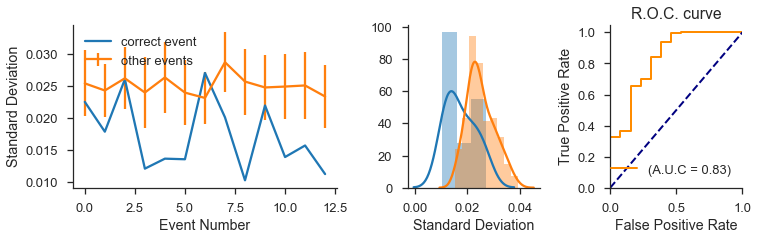

In [14]:
# repeat, but premute the event indicies and orders as a control

motion_data.index = range(len(motion_data))
motion_data_permuted = motion_data[motion_data.columns[:-1]].copy()
motion_data_permuted.index = np.random.permutation(motion_data_permuted.index)
motion_data_permuted['EventNumber'] = motion_data['EventNumber'].copy()
motion_data_permuted.sort_index(axis='index', inplace=True)

def pull_event_permuted(event_number):
    e = motion_data_permuted.loc[motion_data_permuted.EventNumber == event_number, :]
    cols = e.columns[:-1]
    return e[cols].values

sigma_sq = np.zeros(n_events)
sigma_sq_cross = np.zeros((n_events, n_events-1))


for p in tnrange(n_events):
    
    e = pull_event_permuted(p)
    
    # train a model with an event sequence, evaluate it's errors on other event sequences
    X = e[:-1]
    y = e[1:]

    N, D =  X.shape
    model = f_class(D, **f_opts)
    y_hat = np.zeros(y.shape)
    for ii in range(X.shape[0]):
        model.update(X[ii,:], y[ii,:])
        y_hat[ii,:] = model.predict_next(X[ii, :])
        # generate the predicted points in space for the event
    # the model was trained on
    
    # get the variance of the prediction error (similar to the likelihood)
    sigma_sq[p] = np.var(np.array(y - y_hat).flatten()) 

    events = range(n_events)
    events.remove(p)
    for t, p0 in enumerate(events):
        """ Loop through all of the other events and estimate the value of sigma for 
        the given event model"""
        e0 = pull_event_permuted(p0)

        X0 = e0[:-1]
        y0 = e0[1:]
        y0_hat = np.zeros(y0.shape)
        for ii in range(X0.shape[0]):
            y0_hat[ii,:] = model.predict_next(X0[ii, :])
        
        # prediction for the location in space for events the model wasn't trained on
        sigma_sq_cross[p, t] = np.var(np.array(y0 - y0_hat).flatten())

# fit a logistic model where sigma predicts the correct event
X = np.reshape(np.concatenate([sigma_sq, sigma_sq_cross.flatten()]), (-1, 1))
X = sm.add_constant(X)
y = np.reshape(np.concatenate([np.zeros(len(sigma_sq)),
                    np.ones(len(sigma_sq_cross.flatten()))]), (-1, 1))
res = sm.Logit(y, X).fit(disp=0)
y_hat = res.predict(X)

# ROC analysis on the logistic model
fpr, tpr, thr = roc_curve(y, y_hat)
roc_auc = auc(fpr, tpr)
        
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3),
                             gridspec_kw=dict(width_ratios=[2, 1, 1], wspace=0.4))
    
    ax = axes[0]
    ax.plot(sigma_sq, label='correct event')

    x = range(n_events)
    y = np.mean(sigma_sq_cross, axis=1)
    y_err = np.std(sigma_sq_cross,  axis=1)
    ax.errorbar(x, y, y_err, label='other events')
    ax.legend()
    ax.set_xlabel('Event Number')
    ax.set_ylabel('Standard Deviation')
    sns.despine()
    
    sns.distplot(sigma_sq, ax=axes[1], label='correct event')
    sns.distplot(sigma_sq_cross.flatten(), ax=axes[1], label='other events')
    ax.legend()
    axes[1].set_xlabel('Standard Deviation')
    
    
    ax = axes[2]
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='(A.U.C = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('R.O.C. curve')
    plt.legend(loc="lower right")
    plt.show()



As we can see, the permuted events are easily seperable.

# Event Model: Motion Dynamics
A simple question we can ask is what does the event model predict (by event model I mean the class of RNNs trained on a specific event type). Here is an RNN with the same parameters as above trained on a known event.

We run this generatively, initializing at the first point in the event & predicting the next scene in an event

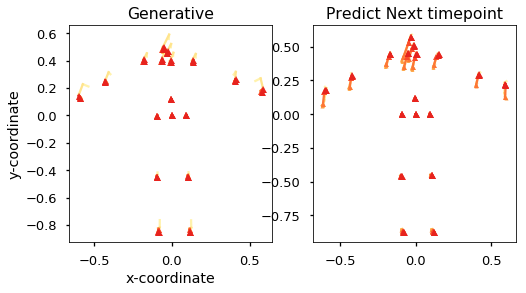

In [18]:
e = motion_data.loc[motion_data.EventNumber == 1, :]
cols = e.columns[:-1]
e = e[cols].values
    
X = e[:-1, :]
y = e[1:, :]
t = t
srn = f_class(D, **f_opts)
for ii in range(X.shape[0]):
    srn.update(X[ii, :], y[ii, :])

def run_generative(model, X):
    """ Run the model generatively, initializing the with the first true 
    scene vector in the event and then using the predicted scene vectors 
    as inputs"""
    model.new_cluster()
    X_gen = np.concatenate([np.reshape(model.predict_f0(), (1, 54))])
    model.update_f0(X_gen[0, :])
    for ii in range(X.shape[0]):
        Y_hat = model.predict_next(X_gen[ii, :])
        model.update(X_gen[ii, :], Y_hat[0, :])
        X_gen = np.concatenate([X_gen, Y_hat])
    return X_gen

def plot_time2d(X, ax):
    cc = sns.color_palette("YlOrRd", n_colors=e.shape[0])
    for ii in range(e.shape[0]-2):
        for jj in range(18):
            ax.plot([X[ii, jj], X[ii+1, jj]],
                     [X[ii, 18+jj], X[ii+1, 18+jj]],
                     color=cc[ii], marker='^', markersize=ii)
            
def predict_update(model, X):
    model.new_cluster()
    Y_hat = np.concatenate([np.reshape(model.predict_f0(), (1, 54))])
    model.update_f0(Y_hat[0, :])
    for ii in range(X.shape[0]):
        Y_hat_ii = model.predict_next(X[ii, :])
        model.update(X[ii, :], Y_hat_ii[0, :])
        Y_hat = np.concatenate([Y_hat, Y_hat_ii])
    return Y_hat

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_time2d(run_generative(srn, X), axes[0]) # generative predicitons, initialized at t=0
plot_time2d(predict_update(srn, X), axes[1]) # predictions based on model observation
axes[0].set_xlabel('x-coordinate')
axes[0].set_ylabel('y-coordinate')
axes[0].set_title('Generative')
axes[1].set_title('Predict Next timepoint')